# Packages and Libraries

In [103]:
import os
import json
import math
# from google.colab import drive
import wave
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf 
from tensorflow.keras import layers, models
import tensorflow.keras as keras

import librosa
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from IPython.display import Audio
import IPython.display as display


In [2]:
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

# Pipeline
-  `Load raw audio data` from files in .WAV format that can be processed
-  `Resample the data` resample audio data to the desired rate.
-  `Normalization` Normalize the audio signal to ensure that the amplitudes are within a specific range
-  `Trimming and Padding` Trim or pad the audio data to a consistent length
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Augmentation` Apply data augmentation techniques to increase the diversity of the training set.
-  `Feature Scaling` Scale the features to have zero mean and unit variance.
-  `Labeling` to associate each audio clip with its corresponding label.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Model Building` Build your machine learning model using the preprocessed data.

# Loading Raw Audio Data

The audio dataset has six(6) classes in  six subfolders with labels: 
- [ `ddyo`   `kkono`  `mu maaso`  `emabega`  `yimirira`  `gaali`]

## Mount google drive
adisamproject@gmail.com

In [4]:
# drive.mount('/content/drive')
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset"
# data_dir = pathlib.Path(DATASET_PATH)

## Locally on the pc

In [5]:
DATASET_PATH = 'own/'
data_dir = pathlib.Path(DATASET_PATH)

PROCESSED_DATA_PATH = 'processedData/'

# Inspect the audio dataset

## Labels

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Number of audio files per command

In [7]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}

    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)

        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count

    return counts

counts = count_audio_files_in_subfolders(data_dir)

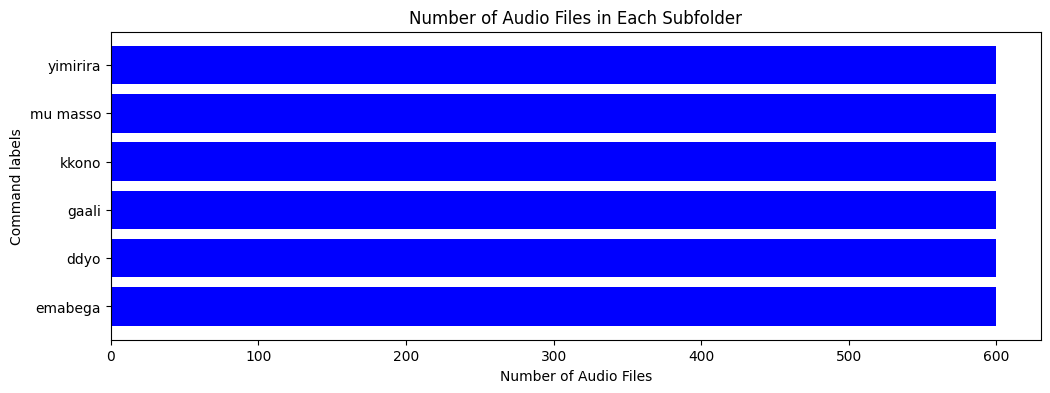

In [8]:
plt.figure(figsize=(12, 4))
plt.barh(list(counts.keys()), list(counts.values()), color='blue')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files in Each Subfolder')
plt.show()

## Audio Properties 
- using one audio file

In [39]:
example_audio_path = os.path.join(DATASET_PATH, 'emabega', 'audio #4251.wav')
audio_signal, sample_rate = librosa.load(example_audio_path)
audio = wave.open(example_audio_path, 'rb')

### Audio Parameters

In [47]:
SAMPLE_RATE = 22050

In [48]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [49]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 16000
Number of frames: 20160
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=20160, comptype='NONE', compname='not compressed')


In [50]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 1.26 seconds
Sample Rate: 22050 Hz


### Visualize the audio waveform

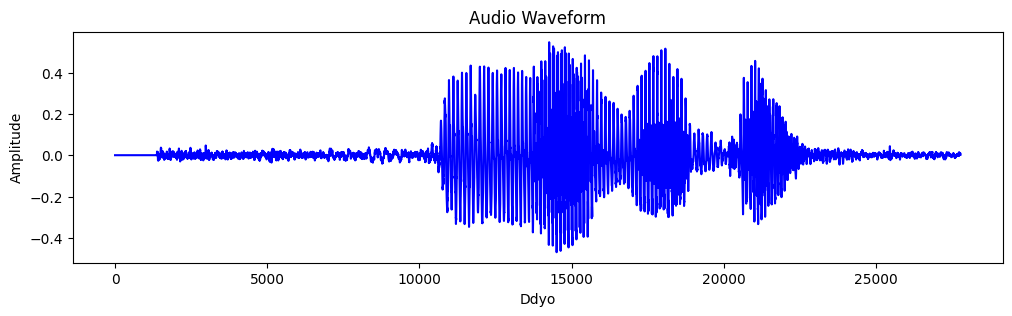

In [51]:
plt.figure(figsize=(12, 3))
plt.plot(audio_signal, color='blue')
plt.title('Audio Waveform')
plt.xlabel('Ddyo')
plt.ylabel('Amplitude')
plt.show()

### Amplitude Distribution

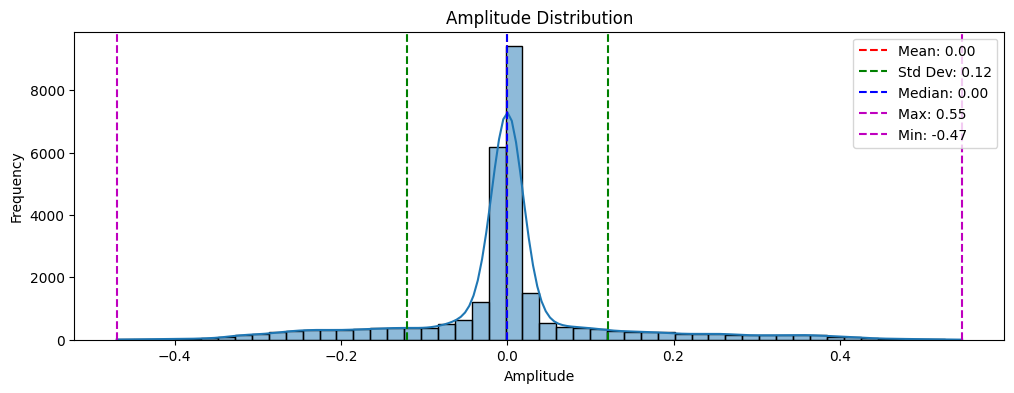

In [52]:
# Calculate statistical summary information
mean_amplitude = np.mean(audio_signal)
std_deviation = np.std(audio_signal)
max_amplitude = np.max(audio_signal)
min_amplitude = np.min(audio_signal)
median_amplitude = np.median(audio_signal)

# Plot the histogram with additional features
plt.figure(figsize=(12, 4))

# Plot the histogram
sns.histplot(audio_signal, bins=50, kde=True)

# Add vertical lines for statistical summary information
plt.axvline(mean_amplitude, color='r', linestyle='--', label=f'Mean: {mean_amplitude:.2f}')
plt.axvline(mean_amplitude + std_deviation, color='g', linestyle='--', label=f'Std Dev: {std_deviation:.2f}')
plt.axvline(mean_amplitude - std_deviation, color='g', linestyle='--')
plt.axvline(median_amplitude, color='b', linestyle='--', label=f'Median: {median_amplitude:.2f}')
plt.axvline(max_amplitude, color='m', linestyle='--', label=f'Max: {max_amplitude:.2f}')
plt.axvline(min_amplitude, color='m', linestyle='--', label=f'Min: {min_amplitude:.2f}')

# Set plot title and labels
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Play audio file

In [53]:
def play_audio(audio_signal, sample_rate):
    return Audio(audio_signal, rate=sample_rate)

play_audio(audio_signal, SAMPLE_RATE)

# Preprocessing audio dataset

## Trim and Pad

In [65]:
def process_audio(audio_path, desired_duration=2):
    # Load audio file
    audio_signal, sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)

    # Pad or trim audio to desired duration
    desired_samples = int(desired_duration * sample_rate)
    if len(audio_signal) < desired_samples:
        # Pad the audio to desired duration
        pad_amount = desired_samples - len(audio_signal)
        processed_signal = np.pad(audio_signal, (0, pad_amount))
    else:
        # Trim the audio to desired duration
        processed_signal = audio_signal[:desired_samples]

    return processed_signal, sample_rate


In [66]:
def preprocess_audio_in_subfolders(root_folder, output_folder, desired_duration=2):
    # Iterate through subfolders
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Create output subfolder if it doesn't exist
            output_subfolder = os.path.join(output_folder, subfolder)
            os.makedirs(output_subfolder, exist_ok=True)

            # Iterate through audio files in the subfolder
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)

                # Process each audio file (trim or pad to desired duration)
                processed_audio, sample_rate = process_audio(audio_path, desired_duration)

                # Save the preprocessed audio file in the output subfolder using soundfile
                output_audio_path = os.path.join(output_subfolder, audio_file)
                sf.write(output_audio_path, processed_audio, sample_rate)



In [78]:
root_folder = DATASET_PATH
output_folder = PROCESSED_DATA_PATH
preprocess_audio_in_subfolders(root_folder, output_folder, desired_duration=2)
data_dir = pathlib.Path(PROCESSED_DATA_PATH)

## Inspect Processed dataset

In [79]:
example_audio_path = os.path.join(PROCESSED_DATA_PATH, 'emabega', 'audio #4251.wav')
audio_signal, sample_rate = librosa.load(example_audio_path)
audio = wave.open(example_audio_path, 'rb')

In [80]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [81]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 22050
Number of frames: 44100
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=44100, comptype='NONE', compname='not compressed')


In [82]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 2.0 seconds
Sample Rate: 22050 Hz


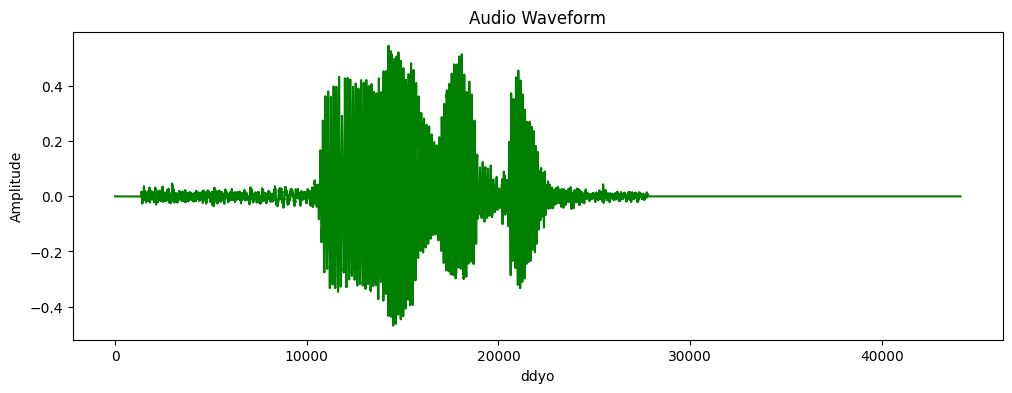

In [83]:
plt.figure(figsize=(12, 4))
plt.plot(audio_signal, color='green')
plt.title('Audio Waveform')
plt.xlabel('ddyo')
plt.ylabel('Amplitude')
plt.show()

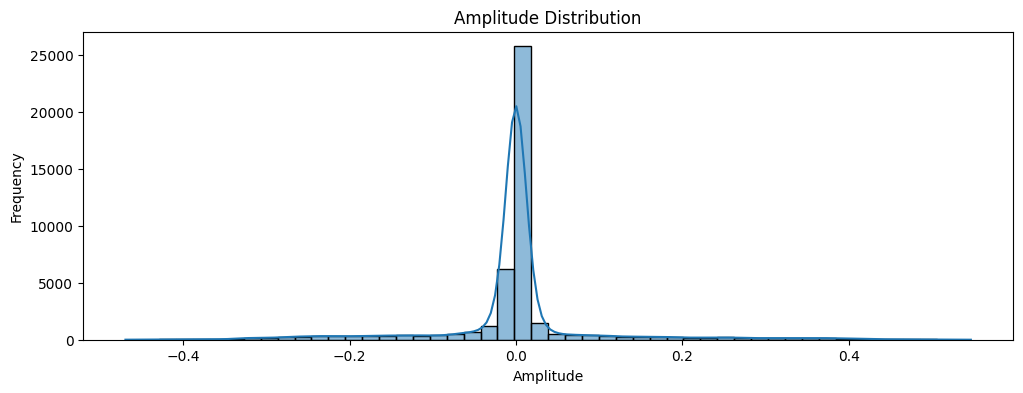

In [84]:
plt.figure(figsize=(12, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()


In [85]:
def play_audio(audio_signal, sample_rate):
    return Audio(audio_signal, rate=sample_rate)

play_audio(audio_signal, SAMPLE_RATE)

# Split into Train and validation

In [92]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3600 files belonging to 6 classes.
Using 2880 files for training.
Using 720 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


## The shape of the audio clip
- `(batch, samples, channels)`

In [93]:
train_ds.element_spec

(TensorSpec(shape=(None, 22050, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [94]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [95]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [96]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 22050)
(64,)


### Plot a few audio waveforms:

In [97]:
label_names[[0,1,2,3,4,5]]

array(['ddyo', 'emabega', 'gaali', 'kkono', 'mu masso', 'yimirira'],
      dtype='<U8')

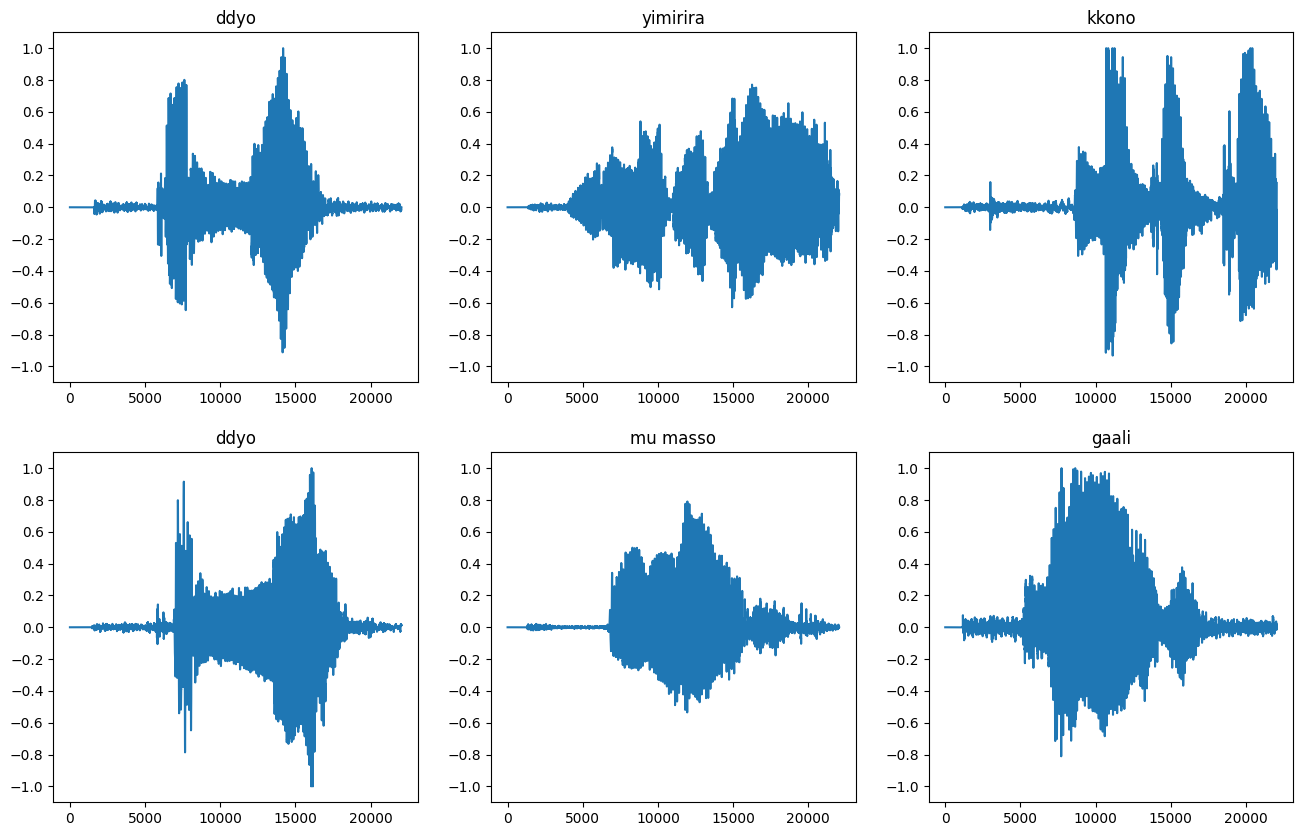

In [98]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Extract Spectrograms

In [99]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio:

In [105]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=SAMPLE_RATE))

Label: ddyo
Waveform shape: (22050,)
Spectrogram shape: (171, 129, 1)
Audio playback


Label: yimirira
Waveform shape: (22050,)
Spectrogram shape: (171, 129, 1)
Audio playback


Label: kkono
Waveform shape: (22050,)
Spectrogram shape: (171, 129, 1)
Audio playback


### Displaying a spectrogram:

In [106]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform over time and the corresponding spectrogram.

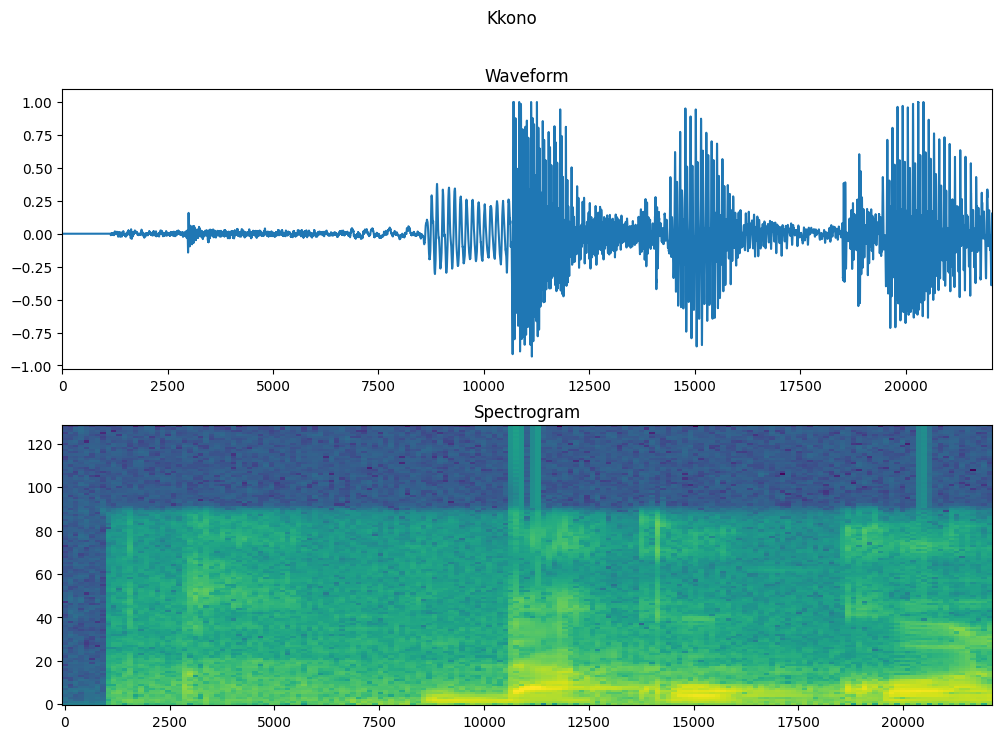

In [108]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, SAMPLE_RATE])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets from the audio datasets:

In [109]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [110]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [111]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

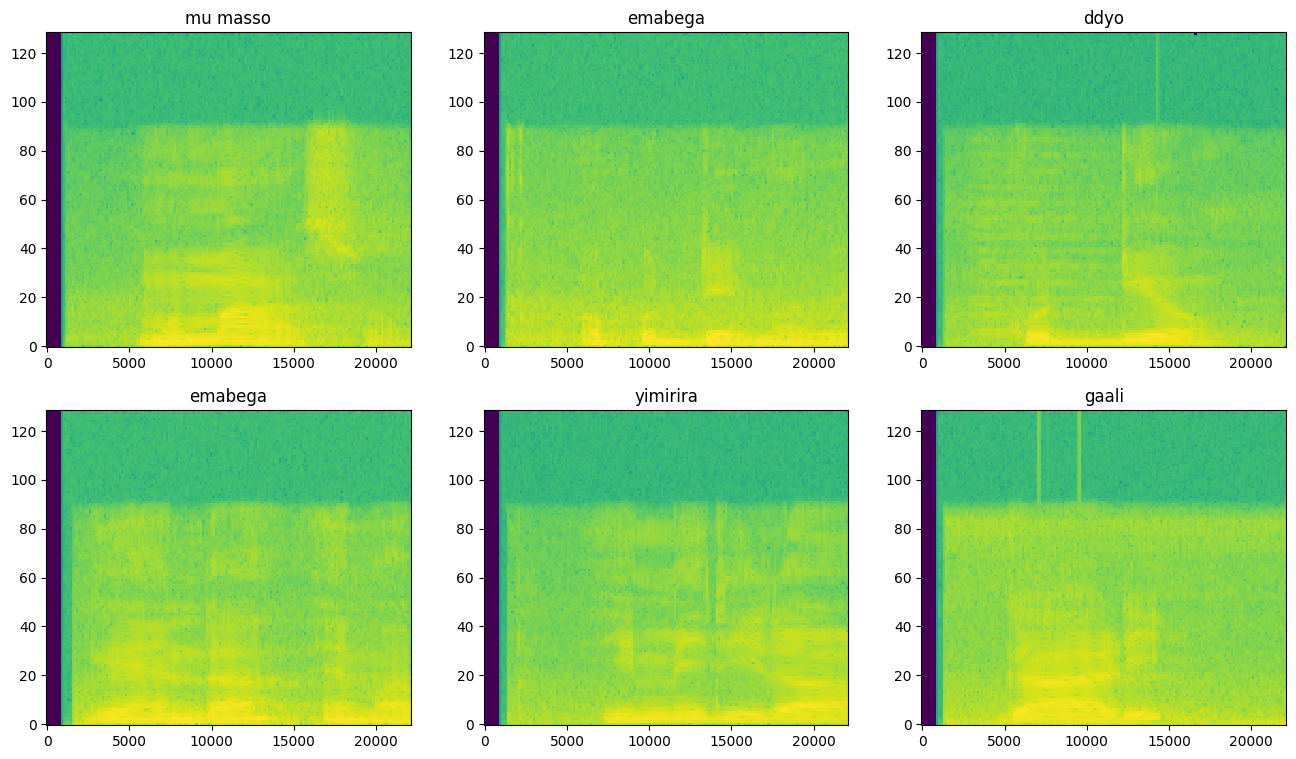

In [112]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

 `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [113]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [114]:
train_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 171, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Building Models

## Model 1

1. **Input Layer:** Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer:** Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer:** Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers:** Two Conv2D layers with ReLU activation functions, followed by max pooling.
5. **Dropout Layer:** Applies dropout regularization to prevent overfitting.
6. **Flatten Layer:** Flattens the output of the previous layer into a 1D vector.
7. **Dense Layers:** Two Dense layers with ReLU activation functions, followed by the output layer with logits for each class.

### Model Arch

In [115]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (171, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

### Compile the model

In [116]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [117]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 12s 211ms/step - loss: 0.8179 - accuracy: 0.6920 - val_loss: 0.3742 - val_accuracy: 0.8839
Epoch 2/10
45/45 [==============================] - 8s 186ms/step - loss: 0.3267 - accuracy: 0.8868 - val_loss: 0.2582 - val_accuracy: 0.9226
Epoch 3/10
45/45 [==============================] - 8s 183ms/step - loss: 0.1991 - accuracy: 0.9330 - val_loss: 0.1549 - val_accuracy: 0.9613
Epoch 4/10
45/45 [==============================] - 8s 184ms/step - loss: 0.1455 - accuracy: 0.9552 - val_loss: 0.1389 - val_accuracy: 0.9643
Epoch 5/10
45/45 [==============================] - 8s 181ms/step - loss: 0.1298 - accuracy: 0.9549 - val_loss: 0.1210 - val_accuracy: 0.9702
Epoch 6/10
45/45 [==============================] - 8s 184ms/step - loss: 0.1000 - accuracy: 0.9715 - val_loss: 0.1151 - val_accuracy: 0.9732
Epoch 7/10
45/45 [==============================] - 8s 184ms/step - loss: 0.0851 - accuracy: 0.9722 - val_loss: 0.1041 - val_accuracy: 0.9762
Epoch

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

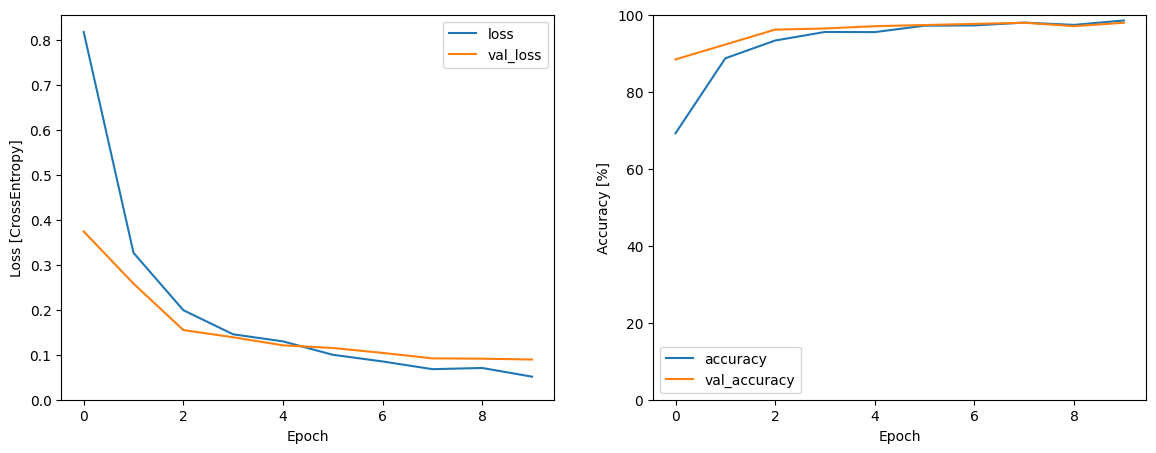

In [118]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [119]:
model.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 1s 123ms/step - loss: 0.0356 - accuracy: 0.9922


{'loss': 0.03555621951818466, 'accuracy': 0.9921875}

### Display a confusion matrix

In [120]:
y_pred = model.predict(test_spectrogram_ds)

6/6 [==============================] - 1s 46ms/step


In [121]:
y_pred = tf.argmax(y_pred, axis=1)

In [122]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

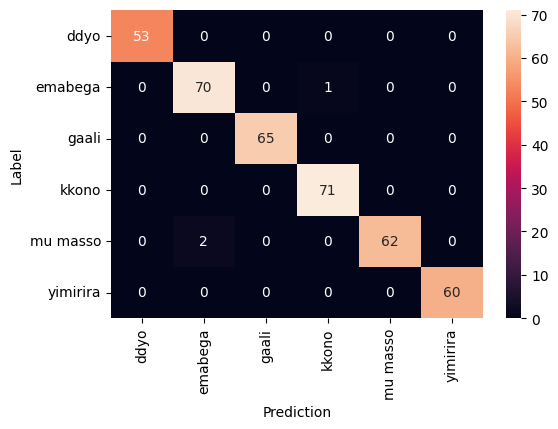

In [123]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 2


1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer**: Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer**: Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers**:
   - 4.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size and ReLU activation function.
   - 4.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 4.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
5. **Convolutional Layers**:
   - 5.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size and ReLU activation function.
   - 5.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 5.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
6. **Dropout Layer**: Applies dropout regularization with a dropout rate of 0.25 to prevent overfitting.
7. **Flatten Layer**: Flattens the output of the previous layer into a 1D vector.
8. **Dense Layers**:
   - 8.1. First Dense Layer: Applies 128 neurons with ReLU activation function.
   - 8.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 8.3. Second Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Model Arch

In [124]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

### Compile the  Model

In [125]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


### Train the Model

In [126]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 8s 103ms/step - loss: 1.0648 - accuracy: 0.6667 - val_loss: 1.5312 - val_accuracy: 0.6071
Epoch 2/10
45/45 [==============================] - 4s 98ms/step - loss: 0.3547 - accuracy: 0.8771 - val_loss: 1.3585 - val_accuracy: 0.5446
Epoch 3/10
45/45 [==============================] - 4s 93ms/step - loss: 0.2192 - accuracy: 0.9205 - val_loss: 1.2241 - val_accuracy: 0.5714
Epoch 4/10
45/45 [==============================] - 4s 97ms/step - loss: 0.1706 - accuracy: 0.9378 - val_loss: 1.1663 - val_accuracy: 0.5327
Epoch 5/10
45/45 [==============================] - 4s 95ms/step - loss: 0.1178 - accuracy: 0.9597 - val_loss: 1.1502 - val_accuracy: 0.5387
Epoch 6/10
45/45 [==============================] - 4s 94ms/step - loss: 0.1028 - accuracy: 0.9649 - val_loss: 1.1366 - val_accuracy: 0.5893
Epoch 7/10
45/45 [==============================] - 4s 95ms/step - loss: 0.0936 - accuracy: 0.9684 - val_loss: 0.9613 - val_accuracy: 0.6667
Epoch 8/10
4

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

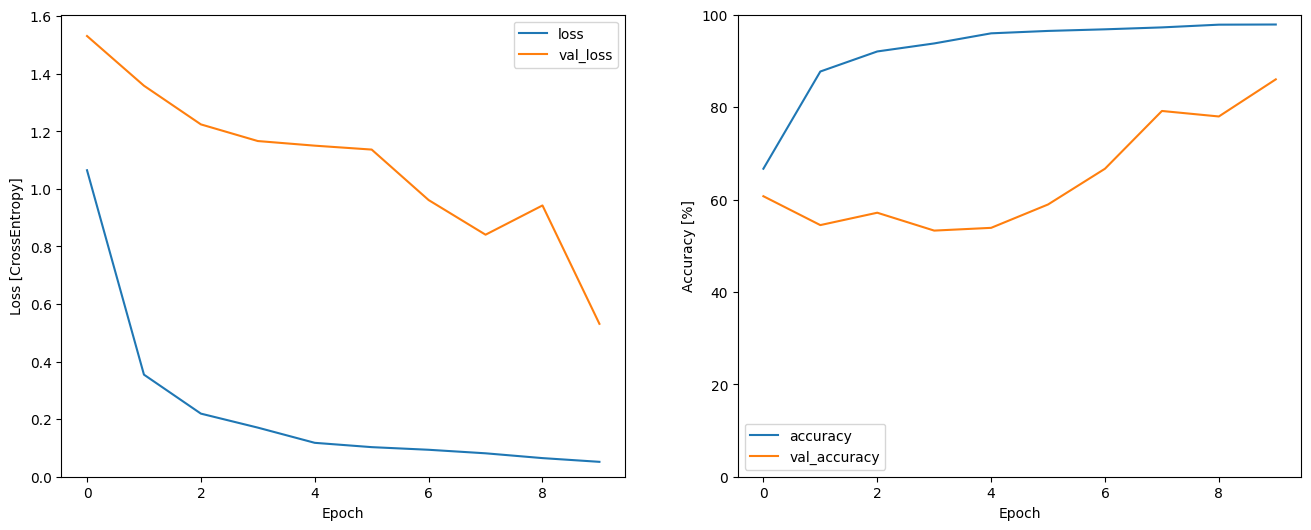

In [127]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [128]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 0s 25ms/step - loss: 0.6099 - accuracy: 0.8516


{'loss': 0.6099424958229065, 'accuracy': 0.8515625}

### Display a confusion matrix

In [129]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

6/6 [==============================] - 0s 23ms/step


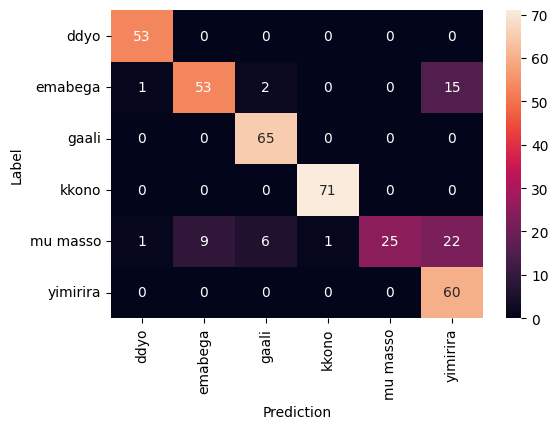

In [130]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Model Arch

In [131]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 167, 125, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 83, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 79, 58, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 39, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 35, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)              

### Model compile

In [132]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [133]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2024-02-12 12:51:39.906440: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 173408256 exceeds 10% of free system memory.
2024-02-12 12:51:39.984055: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 171008000 exceeds 10% of free system memory.
2024-02-12 12:51:40.225798: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42156032 exceeds 10% of free system memory.
2024-02-12 12:51:40.257288: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42663936 exceeds 10% of free system memory.
2024-02-12 12:51:40.310254: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 76021760 exceeds 10% of free system memory.


45/45 [==============================] - 103s 2s/step - loss: 1.5206 - accuracy: 0.3503 - val_loss: 1.0279 - val_accuracy: 0.6101
Epoch 2/10
45/45 [==============================] - 99s 2s/step - loss: 0.8702 - accuracy: 0.6580 - val_loss: 0.6108 - val_accuracy: 0.7679
Epoch 3/10
45/45 [==============================] - 101s 2s/step - loss: 0.5266 - accuracy: 0.8045 - val_loss: 0.4010 - val_accuracy: 0.8482
Epoch 4/10
45/45 [==============================] - 96s 2s/step - loss: 0.3598 - accuracy: 0.8740 - val_loss: 0.3049 - val_accuracy: 0.9137
Epoch 5/10
45/45 [==============================] - 96s 2s/step - loss: 0.2862 - accuracy: 0.8997 - val_loss: 0.2298 - val_accuracy: 0.9226
Epoch 6/10
45/45 [==============================] - 96s 2s/step - loss: 0.2359 - accuracy: 0.9187 - val_loss: 0.2031 - val_accuracy: 0.9286
Epoch 7/10
45/45 [==============================] - 106s 2s/step - loss: 0.2374 - accuracy: 0.9181 - val_loss: 0.1841 - val_accuracy: 0.9464
Epoch 8/10
45/45 [==========

### Plot Loaa and accuracy

Text(0, 0.5, 'Accuracy [%]')

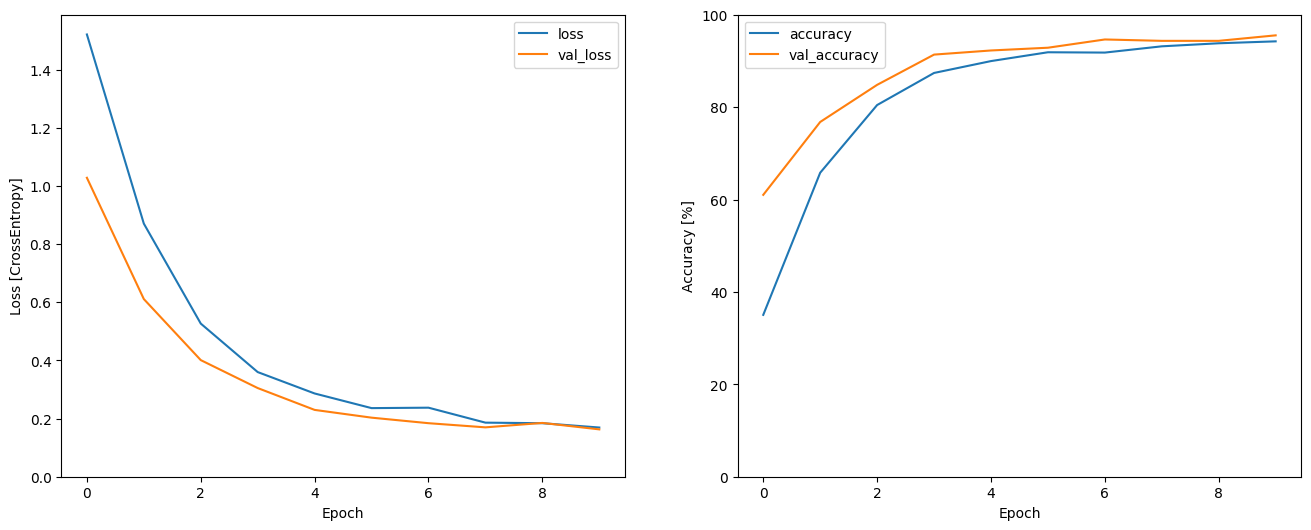

In [134]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [135]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 5s 834ms/step - loss: 0.1314 - accuracy: 0.9557


{'loss': 0.1313600242137909, 'accuracy': 0.9557291865348816}

### Display a confusion matrix

In [136]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

6/6 [==============================] - 5s 851ms/step


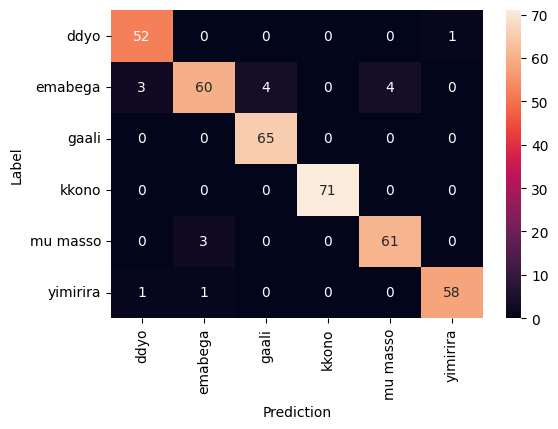

In [137]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Exporting a model

## Export the model with preprocessing

In [150]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, SAMPLE_RATE], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [151]:
export = ExportModel(model)
export(tf.constant(str('own/ddyo/audio #2001.wav')))

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 4.132925  , -0.5847407 , -0.5076784 , -2.7103224 , -0.24181889,
         -4.62111   ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ddyo'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [152]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'kkono'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-4.4591675,  0.78838  , -1.2115194, 14.035884 , -7.2851677,
         -8.294445 ]], dtype=float32)>}